# 1. INTRODUCTION

## 1.1 Dataset

## 1.2 Prerequisites

In [243]:
# !pip install pycountry
# !pip install pycountry_convert
# !pip install hyperopt

Import libraries and packages

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry_convert as pcc
import pycountry as pc
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Set the Random Seed

In [245]:
random_seed = 77
np.random.seed(random_seed)

# 2. DATA VALIDATION AND TRANSFORMATION

Import the file

In [246]:
df = pd.read_csv('./datasets/adult_income.csv')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [247]:
df.shape

(48842, 15)

Check for duplicates

In [248]:
df.duplicated().sum()

52

Drop the relatively few duplicate rows

In [249]:
df.drop_duplicates(inplace = True)

Check data types for inconsistencies

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48790 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48790 non-null  int64 
 1   workclass        48790 non-null  object
 2   fnlwgt           48790 non-null  int64 
 3   education        48790 non-null  object
 4   educational-num  48790 non-null  int64 
 5   marital-status   48790 non-null  object
 6   occupation       48790 non-null  object
 7   relationship     48790 non-null  object
 8   race             48790 non-null  object
 9   gender           48790 non-null  object
 10  capital-gain     48790 non-null  int64 
 11  capital-loss     48790 non-null  int64 
 12  hours-per-week   48790 non-null  int64 
 13  native-country   48790 non-null  object
 14  income           48790 non-null  object
dtypes: int64(6), object(9)
memory usage: 6.0+ MB


Inspect the number of categories per column

In [251]:
obj_cols = df.select_dtypes(include='object').columns

In [252]:
for c in obj_cols:
    print(df[c].value_counts(), '\n', '-'*30)

workclass
Private             33860
Self-emp-not-inc     3861
Local-gov            3136
?                    2795
State-gov            1981
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64 
 ------------------------------
education
HS-grad         15770
Some-college    10863
Bachelors        8013
Masters          2656
Assoc-voc        2060
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           954
Prof-school       834
9th               756
12th              655
Doctorate         594
5th-6th           507
1st-4th           245
Preschool          81
Name: count, dtype: int64 
 ------------------------------
marital-status
Married-civ-spouse       22366
Never-married            16082
Divorced                  6630
Separated                 1530
Widowed                   1518
Married-spouse-absent      627
Married-AF-spouse           37
Name: count, dtype: int64 
 ----------------

Columns with "?" : work-class, and occupation. Replace "?" with np.nan

In [253]:
df.replace('?', np.nan, inplace=True)

In [254]:
df.isna().sum() / df.shape[0] * 100 

age                0.000000
workclass          5.728633
fnlwgt             0.000000
education          0.000000
educational-num    0.000000
marital-status     0.000000
occupation         5.749129
relationship       0.000000
race               0.000000
gender             0.000000
capital-gain       0.000000
capital-loss       0.000000
hours-per-week     0.000000
native-country     1.754458
income             0.000000
dtype: float64

<div class="alert alert-block alert-warning">Findings:
    
1. A few null values : Since the number of nulls are low (<= 6%) the rows can be dropped
2. Never worked and without pay : Can be assumed no income; hence, drop
3. Too granular education: Feature engineer or group similar categories
4. Too granular marital-status: Reduce categories to Married and Single
5. Typographical errors and outdated country names: Fix and transform
6. Too granular native-country: Group countries by geographical region or continent
</div>

1. Drop null values

In [255]:
df.dropna(inplace=True)

2. Drop Never worked and without pay

In [256]:
l_nopay = ['Never-worked', 'Without-pay']
df = df.loc[~df.workclass.isin(l_nopay)]

In [257]:
df.education.unique()

array(['11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th',
       'Prof-school', '7th-8th', 'Bachelors', 'Masters', '5th-6th',
       'Assoc-voc', '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'],
      dtype=object)

<div class="alert alert-block alert-info">
Below will be the mapping of educational attainment and some assumptions made:
    
- **Some-school:** Preschool, K-12 (Did not finish High School)
- **Assoc-grad:** Assoc-acdm, Assoc-voc (Assumed to have finished Associate degrees)

Below values will be retained:

- **HS-grad:** HS-grad (Finished High school)
- **Some-college:** Some-college (Did not finish college)
- **Bachelors:** Bachelors (Assumed to have a college diploma)
- **Prof-school:** Prof-school (Assumed to have completed Professional studies)
- **Masters:** Masters (Assumed to have completed post-graduate Masters degree )
- **Doctorate:** Doctorate (Assumed to have completed post-graduate Doctorate degrees )
</div>

In [258]:
# Apply lambda transformation
df.education = df.education.apply(lambda x: 'Some-school' if [i.isdigit() for i in x][0] else x)
df.education = df.education.apply(lambda x: 'Assoc-grad' if 'Assoc' in x else x)
df.education.value_counts()

education
HS-grad         14756
Some-college     9884
Bachelors        7559
Some-school      5580
Assoc-grad       3463
Masters          2513
Prof-school       785
Doctorate         544
Preschool          70
Name: count, dtype: int64

In [259]:
df.describe(include = 'object').T

,count,unique,top,freq
workclass,45154,6,Private,33262
education,45154,9,HS-grad,14756
marital-status,45154,7,Married-civ-spouse,21029
occupation,45154,14,Craft-repair,6009
relationship,45154,6,Husband,18645
race,45154,5,White,38840
gender,45154,2,Male,30481
native-country,45154,41,United-States,41236
income,45154,2,<=50K,33954


In [260]:
df['marital-status'].value_counts()

marital-status
Married-civ-spouse       21029
Never-married            14561
Divorced                  6294
Separated                 1411
Widowed                   1276
Married-spouse-absent      551
Married-AF-spouse           32
Name: count, dtype: int64

4. Reduce marital status to 2 categories: Married and Single

In [261]:
df['marital-status'] = df['marital-status'].replace('Never-married', 'Single')
df['marital-status'] = df['marital-status'].apply(lambda x: 'Married' if 'Married' in x else 'Single')
df['marital-status'].value_counts()

marital-status
Single     23542
Married    21612
Name: count, dtype: int64

5. Fix typographical errors in countries

In [262]:
df['native-country'] = df['native-country'].str.replace('-', ' ')
df.loc[df['native-country'] == 'South']['race'].value_counts()

race
Asian-Pac-Islander    98
Amer-Indian-Eskimo     2
White                  1
Name: count, dtype: int64

The only country in Asia / Pacific with 'South' in its name is South Korea. Rename the entry along with other countries

In [263]:
df['native-country'] = df['native-country'].str.replace('South', 'South Korea')

# Fix the rest of the native-country data
df['native-country'] = df['native-country'].str.replace('Trinadad&Tobago', 'Trinidad and Tobago')
df['native-country'] = df['native-country'].str.replace('Hong', 'Hong Kong')
df['native-country'] = df['native-country'].str.replace('Outlying US(Guam USVI etc)', 'United States')
df['native-country'] = df['native-country'].str.replace('Columbia', 'Colombia')
df['native-country'] = df['native-country'].str.replace('England', 'United Kingdom')
df['native-country'] = df['native-country'].str.replace('Scotland', 'United Kingdom')
df['native-country'] = df['native-country'].str.replace('Yugoslavia', 'Serbia')
df['native-country'] = df['native-country'].str.replace('Holand Netherlands', 'Netherlands')

6. Convert countries to geographical regions

In [264]:
df['native-country'] = df['native-country'].apply(lambda x: pcc.country_alpha2_to_continent_code(pcc.country_name_to_country_alpha2(x, cn_name_format="default")))
df['native-country'].value_counts()

native-country
NA    43217
AS     1029
EU      738
SA      170
Name: count, dtype: int64

# 3. EXPLORATORY DATA ANALYSIS

Explore Numeric Features

In [265]:
sns.set_style('darkgrid')

First, check for outliers

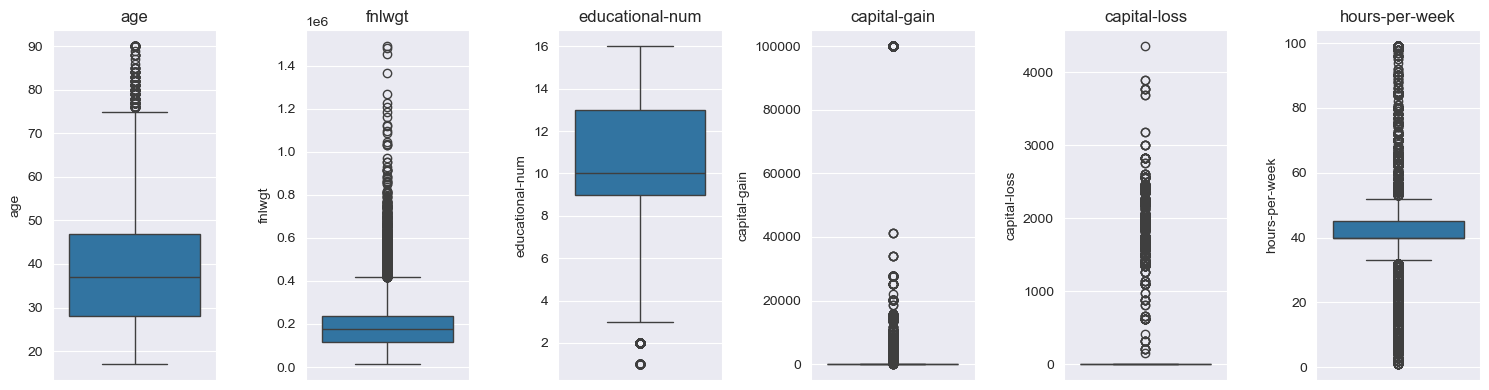

In [266]:
df_num = df.select_dtypes(include=['number'])

# Numerical columns/features  
num_cols = df_num.columns
        
# Create a figure
plt.figure(figsize=(15, 4))

x = 0
for col in num_cols:
    x += 1
    plt.subplot(1, 6, x)
    sns.boxplot(data=df[col])
    plt.title(col)

plt.tight_layout() 
plt.show()

Explore and visualize numerical features

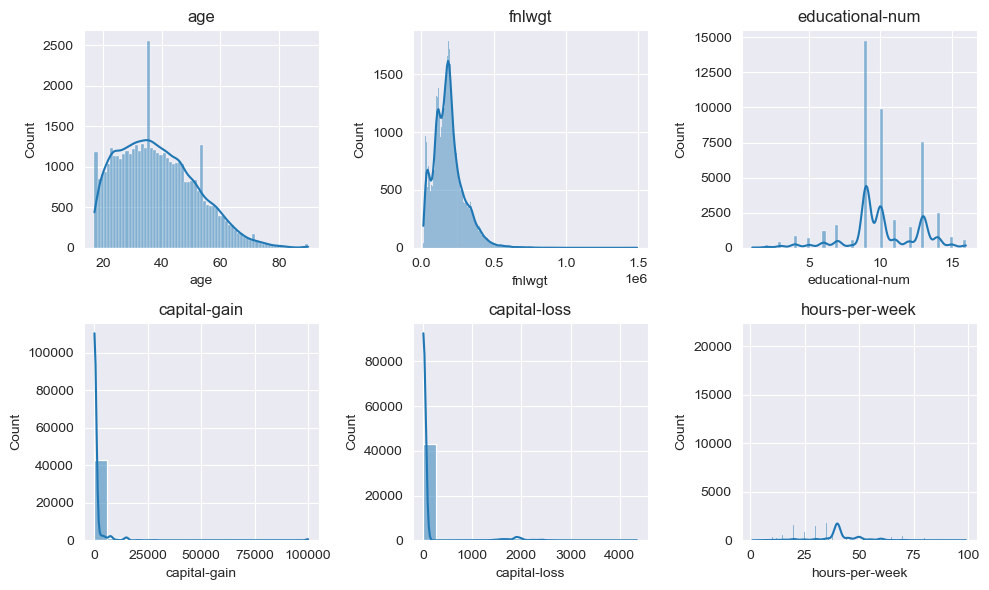

In [267]:
# columns = num_cols
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten()

for i, column in enumerate(num_cols):
    sns.histplot(df[column], kde=True, ax=axes[i])
    axes[i].set_title(column)
    
for i in range(len(num_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

*Note: Final Weight: fnlwgt denotes the estimated people each row the census believes it represents.\
Source: https://cseweb.ucsd.edu/classes/sp15/cse190-c/reports/sp15/048.pdf

Final weight, capital gain/loss fields are not very useful since they generally contain bad data and zero values.\
These fields need to be ommitted in the prediction. 


In [268]:
df.drop(['fnlwgt', 'capital-loss', 'capital-gain'], axis=1, inplace=True)

Explore numerical relationships in Numeric features

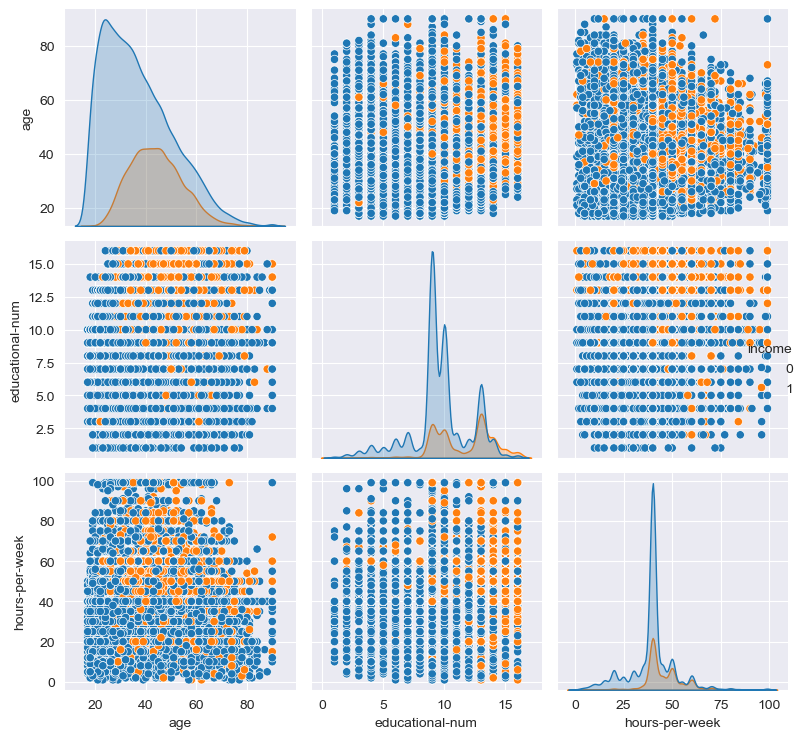

In [269]:
from sklearn.preprocessing import LabelEncoder
df2 = df_num.drop(['fnlwgt', 'capital-loss', 'capital-gain'], axis=1)

df2['income'] =  LabelEncoder().fit_transform(df['income'])
sns.pairplot(df2, hue='income')

plt.tight_layout()
plt.show()

In [270]:
df.groupby('income')['hours-per-week'].agg('median')

income
<=50K    40.0
>50K     40.0
Name: hours-per-week, dtype: float64

<div class="alert alert-block alert-warning">
Key Findings:
<li>The median hours-per-week for both high-income and low-income are the same (40 hrs)</li> 
<li>High-income earners have higher Educational-num </li>
</div>

Explore and visualize Categorical features

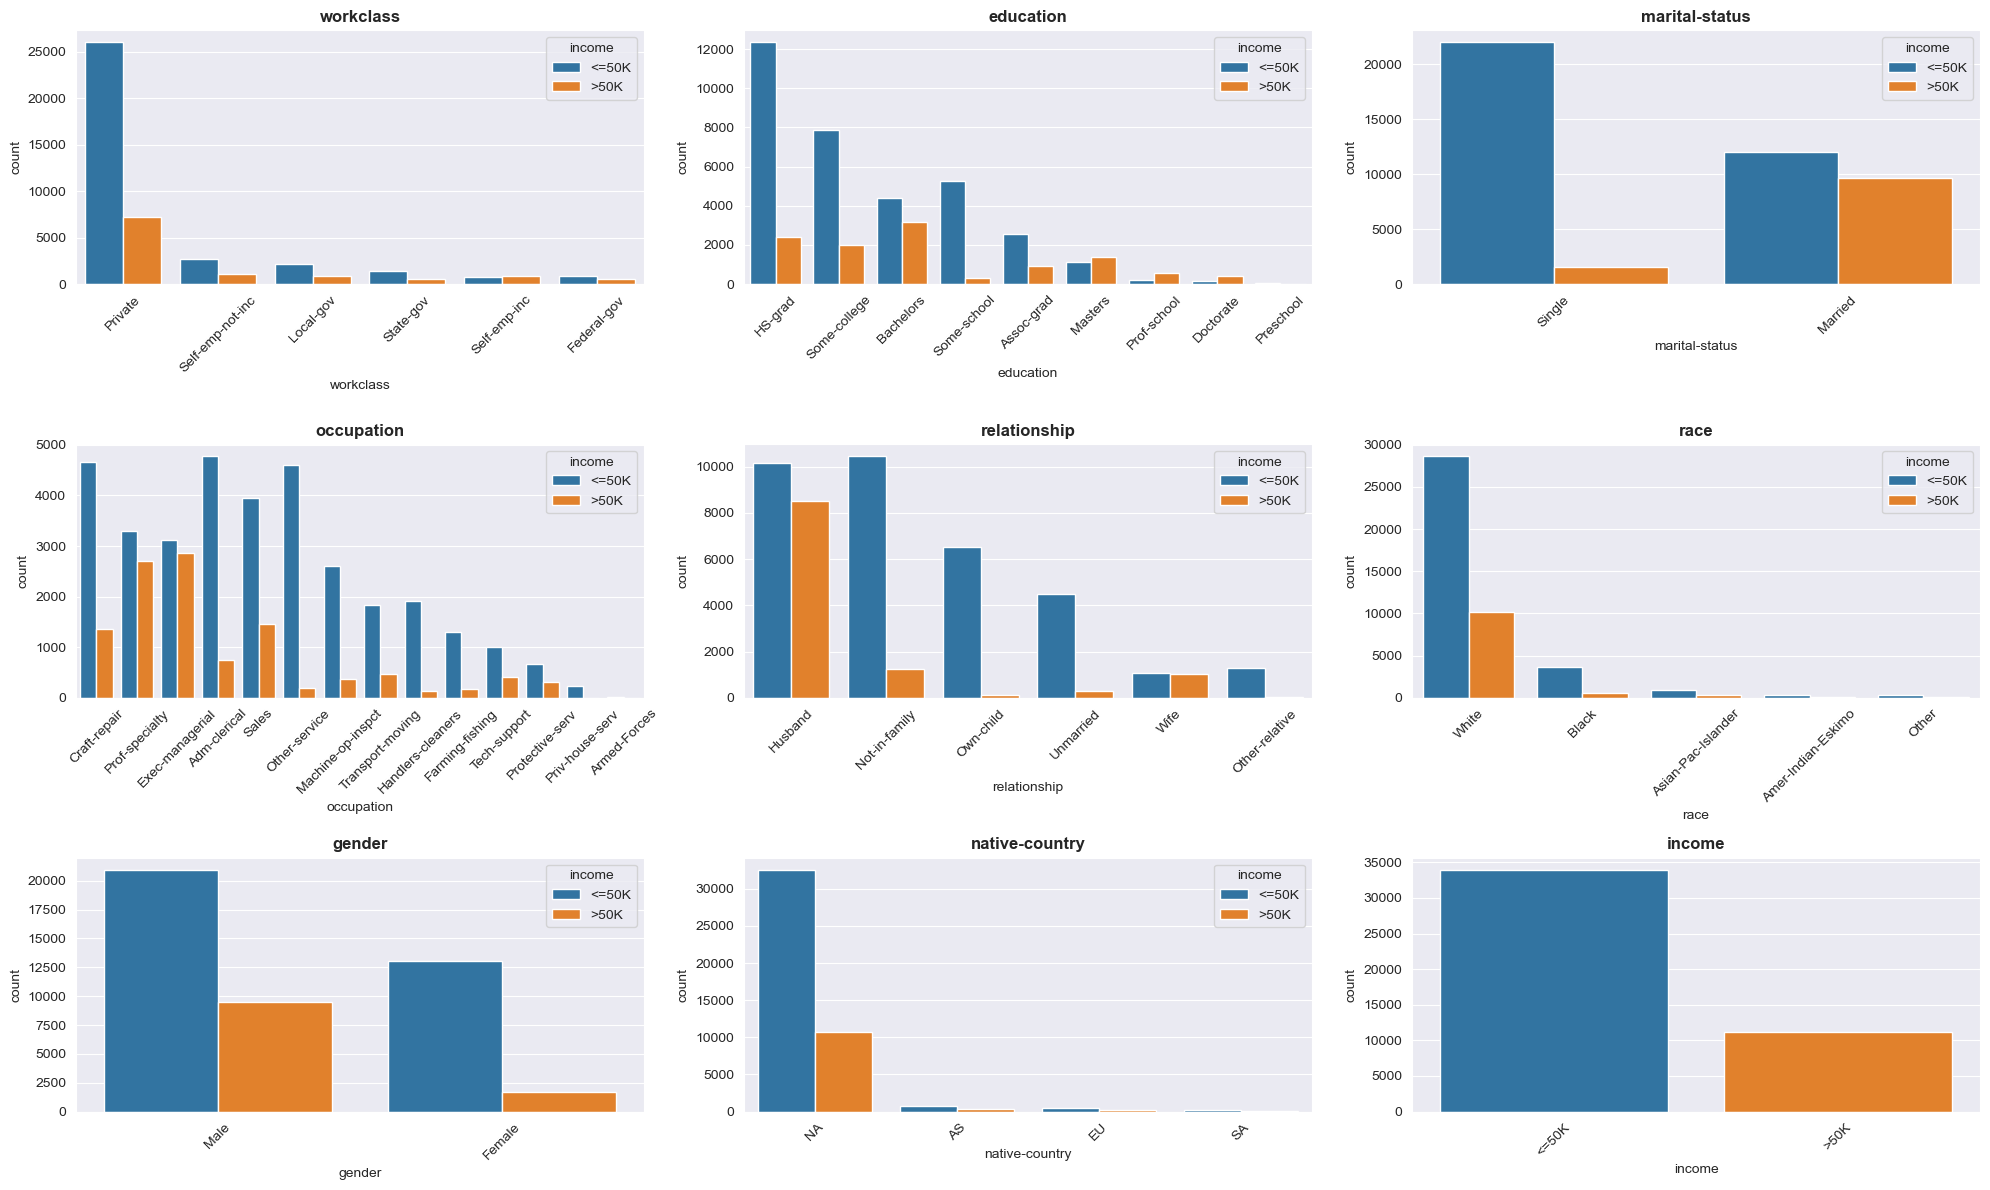

In [271]:
df_obj = df.select_dtypes(include=['object'])

n_cols = 3
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, column in enumerate(obj_cols):
    ax1 = sns.countplot(data = df_obj, x=column, hue=df_obj.income, order=df_obj[column].value_counts().index, ax=axes[i])
    axes[i].set_title(column, weight='bold')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    
for i in range(len(obj_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">Key Findings:

- Individuals who attended professional and post-graduate studies tend to have higher incomes than those who did not. 
- More married individuals are in the higher income category compared to single individuals.
- The proportion of high-to-low income brackets is higher in males than in females.

</div>

Zoom in on individuals with college and post-graduate degrees.

In [272]:
l_degrees = ['Bachelors', 'Prof-school', 'Masters', 'Doctorate' ] 

pvt_educ = df.pivot_table(values='age', index='education', columns='income', fill_value=0, aggfunc='count', margins=True).reset_index()  

melt_educ = pd.melt(pvt_educ.iloc[:-1].drop('All', axis = 1), 
                    id_vars = ['education'],  
                    var_name='income', 
                    value_vars=['<=50K', '>50K'], 
                    value_name='count').sort_values('education')

gby_educ = melt_educ.groupby('education')['count'].agg('sum')

mrgd_educ = melt_educ.merge(gby_educ, on='education', how='left', suffixes=('', '_Total'))
mrgd_educ['percentage'] = round((mrgd_educ['count'] / mrgd_educ['count_Total'])*100, 2)

df_degree = mrgd_educ[mrgd_educ['education'].isin(l_degrees)]
df_degree

,education,income,count,count_Total,percentage
2,Bachelors,<=50K,4383,7559,57.98
3,Bachelors,>50K,3176,7559,42.02
4,Doctorate,<=50K,145,544,26.65
5,Doctorate,>50K,399,544,73.35
8,Masters,<=50K,1120,2513,44.57
9,Masters,>50K,1393,2513,55.43
12,Prof-school,<=50K,193,785,24.59
13,Prof-school,>50K,592,785,75.41


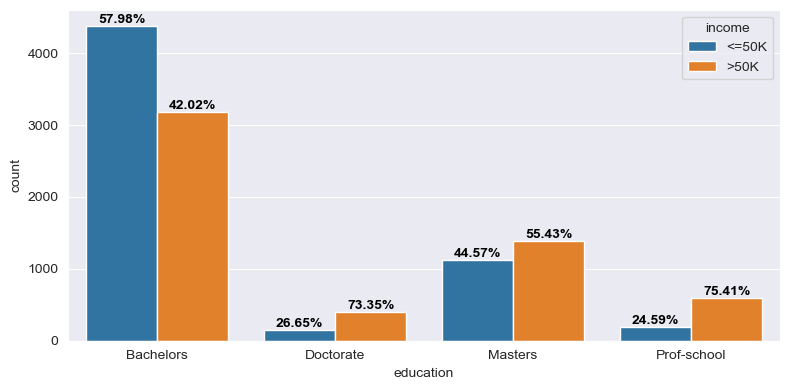

In [273]:
plt.figure(figsize=(8,4))
sns.barplot(df_degree, x='education', y='count', hue='income')

for p in plt.gca().patches:
    width = p.get_width()
    height = p.get_height()
    percentage = df_degree.loc[(df_degree['count'] >= height - 0.01) & (df_degree['count'] <= height + 0.01), 'percentage']
    if not percentage.empty:
        plt.text(p.get_x() + width / 2, height, f"{percentage.values[0]:.2f}%", ha="center", va="bottom", color='black', weight='bold')

plt.tight_layout()
plt.show()

Explore features correlation

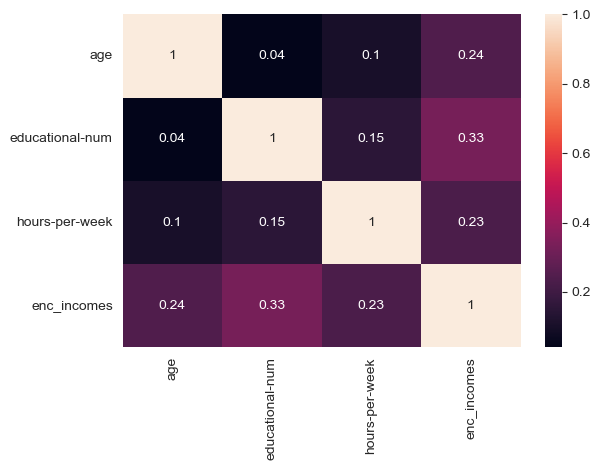

In [274]:
df_num = df.select_dtypes(exclude='object')

df_num['enc_incomes'] = LabelEncoder().fit_transform(df['income'])

sns.heatmap(df_num.corr().round(2), annot=True)
plt.tight_layout()
plt.show()

# 4. PRE-PROCESSING

## 4.1 Dealing with Class imbalance

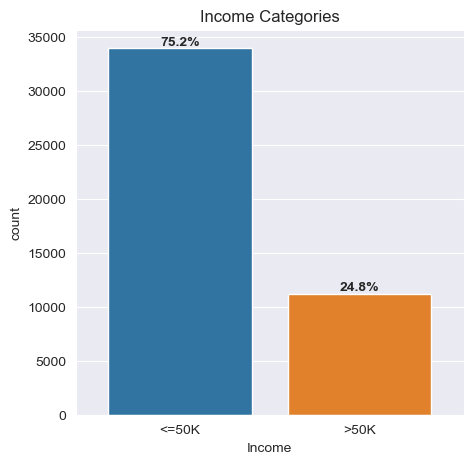

In [275]:
plt.figure(figsize=(5,5))
ax = sns.countplot(data=df, x='income', hue='income' )

total = df.income.count()

for contr in ax.containers:
    ax.bar_label(contr, fmt = lambda x: f'{(x/total)*100:0.1f}%', weight='bold' )

ax.margins(x=0.1)

ax.set(xlabel='Income', ylabel='count', title='Income Categories')
plt.show()
#Class imbalance

Since there's a class imbalance, ensure the splitting is stratified, and set the class_weight set to 'balanced'. 

## 4.2 Feature Selection

Encode labels and categorical features

In [277]:
from sklearn.preprocessing import LabelEncoder

df_enc = df.copy(deep=True)
le = LabelEncoder()

lbl_mapping = {}
for col in df_enc.select_dtypes(include = 'object').columns:
    
    df_enc[col] = le.fit_transform(df_enc[col])
    match col:
        case 'income':
            lbl_mapping = dict(zip(le.classes_, le.transform(le.classes_ )) )
lbl_mapping

{'<=50K': 0, '>50K': 1}

Perform Chi-Squared test for categorical variables

In [280]:
from sklearn.feature_selection import chi2
X = df_enc.drop('income', axis=1)
y = df_enc['income']

chi_results = chi2( X, y )
chi_results

(array([1.15e+04, 5.00e+00, 1.96e+03, 3.22e+03, 4.14e+03, 3.03e+02,
        5.24e+03, 4.27e+01, 6.84e+02, 8.19e+03, 1.95e+00]),
 array([0.00e+000, 2.53e-002, 0.00e+000, 0.00e+000, 0.00e+000, 8.10e-068,
        0.00e+000, 6.25e-011, 1.07e-150, 0.00e+000, 1.62e-001]))

<div class="alert alert-block alert-warning">Testing the association of each categorical column and income at $\alpha$ = 0.05:

- H0 = There is NO significant association between each of the categorical columns and income.
- HA = There is a significant association between each of the categorical columns and income.


</div>

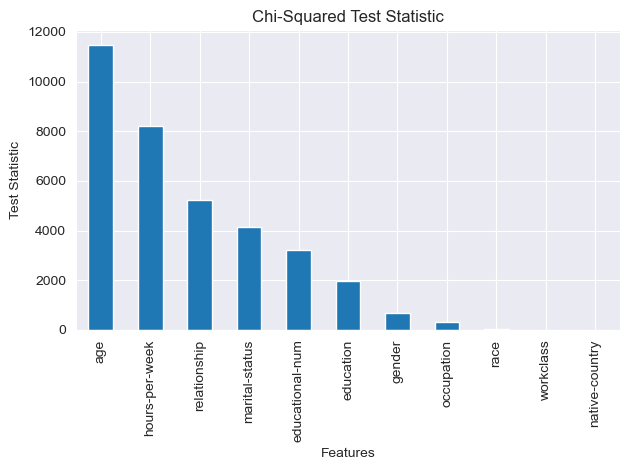

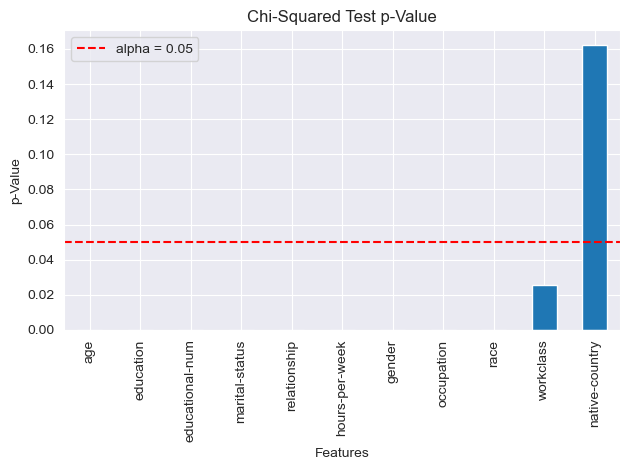

In [281]:
alpha = 0.05
chi_scores = pd.Series(chi_results[0], index=X.columns).sort_values(ascending=False)
p_values = pd.Series(chi_results[1], index=X.columns).sort_values()

plt.figure()
chi_scores.plot.bar()
plt.xlabel('Features')
plt.ylabel('Test Statistic')
plt.title('Chi-Squared Test Statistic')
plt.tight_layout()
plt.show()

plt.figure()
p_values.plot.bar()
plt.xlabel('Features')
plt.ylabel('p-Value')
plt.title('Chi-Squared Test p-Value')
plt.axhline(y=alpha, linestyle='--', color='red', label=f'alpha = {alpha}')
plt.legend()
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">

For native-country, we accept the H0  - There is NO significant association between this feature and label, income. \
The column will be dropped for the subsequent modeling. 
</div>

In [283]:
df.drop('native-country', axis=1, inplace=True)

## 4.3 Dummy Features

Convert categorical features into dummy/indicator features

In [288]:
# Again, determine the object and numeric columns from the newly transformed df. 
df_obj = df.select_dtypes(include='object')
df_num = df.select_dtypes(exclude='object')

,workclass,education,marital-status,occupation,relationship,race,gender,income
0,Private,Some-school,Single,Machine-op-inspct,Own-child,Black,Male,<=50K
1,Private,HS-grad,Married,Farming-fishing,Husband,White,Male,<=50K
2,Local-gov,Assoc-grad,Married,Protective-serv,Husband,White,Male,>50K
3,Private,Some-college,Married,Machine-op-inspct,Husband,Black,Male,>50K
5,Private,Some-school,Single,Other-service,Not-in-family,White,Male,<=50K
...,...,...,...,...,...,...,...,...
48837,Private,Assoc-grad,Married,Tech-support,Wife,White,Female,<=50K
48838,Private,HS-grad,Married,Machine-op-inspct,Husband,White,Male,>50K
48839,Private,HS-grad,Single,Adm-clerical,Unmarried,White,Female,<=50K
48840,Private,HS-grad,Single,Adm-clerical,Own-child,White,Male,<=50K


In [289]:
df_dum = pd.get_dummies(df_obj.drop('income', axis=1))
df = df_num.merge(df_dum, left_index=True, right_index=True)
df.shape

(45154, 47)

# 5. MODELING

## 5.1 Splitting into Train/Test sets

Split datasets into train and test sets

In [291]:
X=df
y=df_enc['income']

print(X.shape, y.shape)

(45154, 47) (45154,)


In [292]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state = random_seed )

In [294]:
np.array(np.unique(y_train, return_counts=True)).T

array([[    0, 25465],
       [    1,  8400]], dtype=int64)

In [295]:
np.array(np.unique(y_test, return_counts=True)).T

array([[   0, 8489],
       [   1, 2800]], dtype=int64)

## 5.2 Data Scaling

In [296]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5.3 Hyperparameter Tuning 

In [298]:
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp, tpe, rand, fmin, Trials, STATUS_OK, space_eval
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss

In [299]:
rfc_space = {
    'n_estimators': hp.uniformint('n_estimators', 100, 500, q=100),
    'criterion' : hp.choice('criterion', ['gini', 'entropy']),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
    'max_depth' :hp.uniformint('max_depth', 1, 10, q=1),
    'min_samples_split': hp.uniformint('min_samples_split', 2, 6, q=1),
}

In [300]:
def rfc_objective(space):

    np.random.seed(random_seed)
    np.random.default_rng(random_seed)
    
    
    rfc = RandomForestClassifier(n_estimators = space['n_estimators'],
                                 criterion = space['criterion'],
                                 max_features = space['max_features'],
                                 max_depth = space['max_depth'],
                                 min_samples_split = space['min_samples_split'],
                                 class_weight = 'balanced',
                                 random_state = random_seed
                                )
    
    rfc.fit(X_train_scaled, y_train)
    y_pred = rfc.predict_proba(X_test_scaled)

    loss = log_loss(y_test, y_pred)        
         
    return {'loss' : loss, 'status': STATUS_OK }


In [301]:
trials = Trials()    
smbo_res = fmin( fn = rfc_objective, 
                        space = rfc_space,
                        algo  = tpe.suggest,
                        max_evals = 50, 
                        trials = trials,
                        rstate = np.random.default_rng(random_seed))    
    
losses = trials.losses()
print('Min and max loss: ', min(losses), max(losses))

smbo_best = space_eval(rfc_space, smbo_res)
print('SMBO Best params :', smbo_best ) 

100%|█████████████████████████████████████████████████| 50/50 [02:11<00:00,  2.64s/trial, best loss: 0.419248039846795]
Min and max loss:  0.419248039846795 0.5920476561680806
SMBO Best params : {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 316}


## 5.4 Re-building the model

In [302]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier())])

pipe.set_params (clf__n_estimators = smbo_best['n_estimators'],
                 clf__criterion = smbo_best['criterion'], 
                 clf__max_features = smbo_best['max_features'],
                 clf__max_depth = smbo_best['max_depth'],
                 clf__min_samples_split = smbo_best['min_samples_split'] )

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_pred_proba  = pipe.predict_proba(X_test)


ac = accuracy_score(y_pred, y_test)
lo = log_loss(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print('Training Data Set 1 Random Forest: Accuracy=%.3f' % (ac))
print('Training Data Set 1 Random Forest: Log loss=%.3f' % (lo))
print('Training Data Set 1 Random Forest: f1-score=%.3f' % (f1))

Training Data Set 1 Random Forest: Accuracy=0.837
Training Data Set 1 Random Forest: Log loss=5.881
Training Data Set 1 Random Forest: f1-score=0.827


Map class names from labels

In [303]:
class_names = list(lbl_mapping.keys())
class_names

['<=50K', '>50K']

Plot the confusion matrices

Confusion matrix, without normalization
[[7981  508]
 [1334 1466]]
Normalized confusion matrix
[[0.94 0.06]
 [0.48 0.52]]


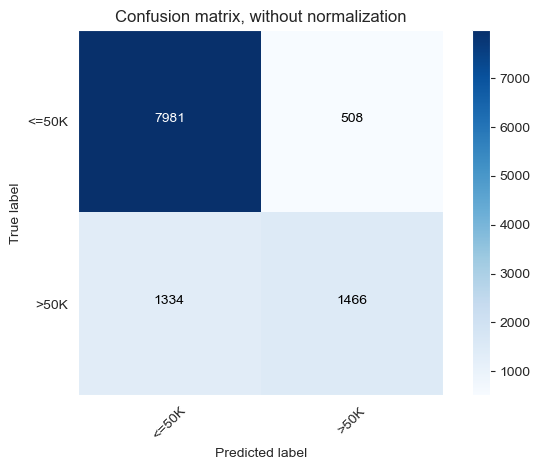

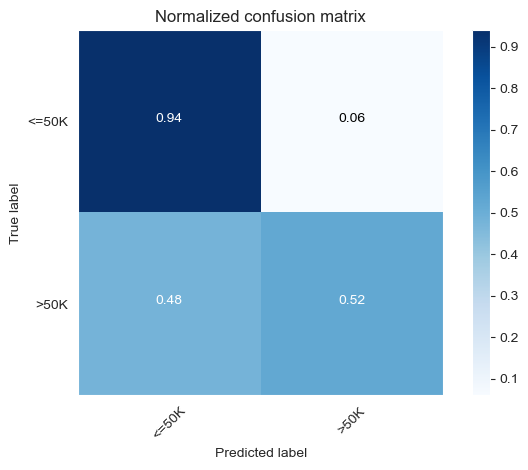

In [304]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

Show Feature Importance

30


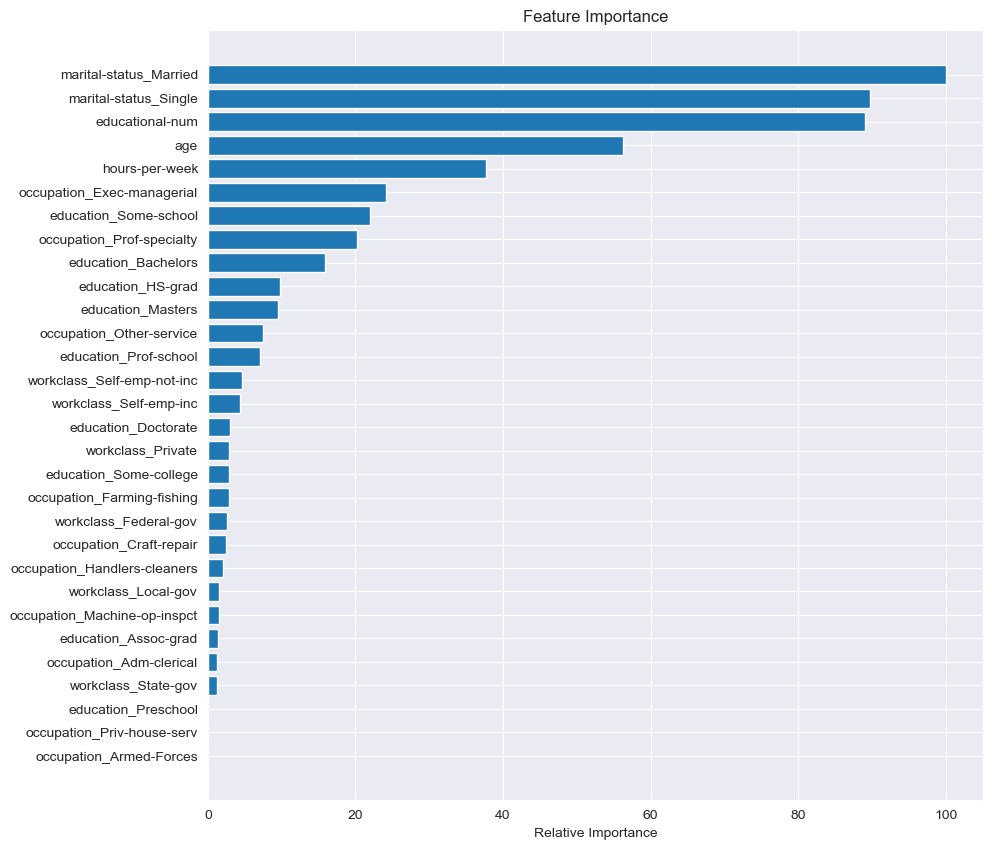

In [305]:
feature_importance = pipe['clf'].feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()
